## Conformational clustering of a protein

In this tutorial, we will perform and analyze conformational clustering of protein using coordinate-based PCA. This is the simplest for of the clustering that can be performed.

### Instructions
* **Tutorial files**: The tutorial files can be downloaded from [here](https://figshare.com/ndownloader/files/55894172).
* **Extract the files**: `tar -zxvf protein-pca.tar.gz`
* **Go to directory**: `cd protein-pca`
* **Copy the Jupyter Notebook**: This notebook is available in the GitHub repo. [Download and copy it from the github](https://github.com/rjdkmr/gmx_clusterByFeatures/tree/master/docs/tutorials).

### Required Tools
* GROMACS
* gmx_clusterByFeatures

### Steps
1. PCA of the protein
2. Calculation of projections on first five PCs
3. Calculation of Cluster-Metrics
4. Final Clustering
5. Analysis


### 1. PCA of the protein

We will use GROMACS tools `gmx covar` to perform the PCA. Here, we will perform PCA of protein's C-Alpha atoms coordinates.

This step will calculate covariance matrix, eigenvectors and eigenvalues. By default, the eigenvectors are written in `eigenvec.trr` while eigenvalues are written in `eigenval.xvg` files.

**Note:** Both index groups here is "C-alpha" because it is used both for covariance calculation and structure superimposition on the reference conformation.

In [1]:
%%bash

echo 3 3 | gmx covar -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -mwa

                      :-) GROMACS - gmx covar, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-pca
Command line:
  gmx covar -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -mwa

Reading file inputs/onlyProtein.tpr, VERSION 5.1.2 (single precision)
Reading file inputs/onlyProtein.tpr, VERSION 5.1.2 (single precision)
Group     0 (         System) has  8327 elements
Group     1 (        Protein) has  8327 elements
Group     2 (      Protein-H) has  4217 elements
Group     3 (        C-alpha) has   542 elements
Group     4 (       Backbone) has  1626 elements
Group     5 (      MainChain) has  2169 elements
Group     6 (   MainChain+Cb) has  2660 elements
Group     7 (    MainChain+H) has  2668 elements
Group     8 (      SideChain) has  5659 elements
Group     9 (    SideChain-H) has  2048 elements
Group    10 (r_5-535_&_MainChain) has  2124 element


Choose a group for the least squares fit
Selected 3: 'C-alpha'

Choose a group for the covariance analysis
Selected 3: 'C-alpha'


### 2. Calculate projections on first five PCs

We will use eigenvectors `eigenvec.trr` as input files to GROMACS tool `gmx anaeig` to calculate projection of first 5 eigenvectors on trajectory. These projections will be written into `proj.xvg` file by default.

In [2]:
%%bash

echo 3 3 | gmx anaeig -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -proj -first 1 -last 10

                      :-) GROMACS - gmx anaeig, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-pca
Command line:
  gmx anaeig -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -proj -first 1 -last 10

trr version: GMX_trn_file (single precision)
Read non mass weighted reference structure with 542 atoms from eigenvec.trr
Read mass weighted average/minimum structure with 542 atoms from eigenvec.trr
Read 1626 eigenvectors (for 542 atoms)

Reading file inputs/onlyProtein.tpr, VERSION 5.1.2 (single precision)
Reading file inputs/onlyProtein.tpr, VERSION 5.1.2 (single precision)
Group     0 (         System) has  8327 elements
Group     1 (        Protein) has  8327 elements
Group     2 (      Protein-H) has  4217 elements
Group     3 (        C-alpha) has   542 elements
Group     4 (       Backbone) has  1626 elements
Group     5 (      MainChain) has  2


Select the index group that was used for the least squares fit in gmx covar
Selected 3: 'C-alpha'

Select an index group of 542 elements that corresponds to the eigenvectors
Selected 3: 'C-alpha'



### 3. Calculation of Cluster-Metrics

Before performing final clutering, we would first generate cluster-mterics that can be used to make a decision on the number of clusters. One of the **drawback** of [K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering) is that the number of clusters should be known beforehand. Although, `gmx_clusterByFeatures` implements several [cluster metrics](https://gmx-clusterbyfeatures.readthedocs.io/en/latest/commands/cluster.html#cmetric-prior) and also automatated way to decide number of clusters, here, we first calculate cluster-metrics and final clustering can be performed later.

Following command will perform the clustering of conformations using first 5 PCs projection. Explanation of options are as follows:
* `-method kmeans`: Use K-Means clustering algorithm
* `-ncluster 10`: K-Means clustering will be performed for 1 upto 10 clusters times each time. Finally, based on `-ssrchange` option, final number of clusters will be automatically selected.
* `-cmetric ssr-sst`: Use Elbow method to decide final number of clusters.
* `-nfeature 5`: Take 5 feature from `feat proj.xvg` input file. Here it is projection of first 5 eigenvectors on the trajectory.
* `-sort features`: Sort the output clustered trajectory based on the distance in feature space from its central structure.
* `-fit2central`: Fit/Superimpose the conformation on cluster's central structure in output clustered trajectory.
* `-ssrchange 2`: Threshold (percentage) of change in SSR/SST ratio in Elbow method to automatically decide the number of clusters.
* `-g clusters_scan.log`: Log file containing clustering information and cluster-mterics.
* `-plot pca_cluster.png`: Plot the feature-space (here, it is first 5 PCs from PCA) coloured by the clusters.

**index group order**

1. **First index** group - Output group of atoms in the central structures and clustered trajectories

2. **Second index** group - Group of atoms to calculate RMSD between central conformations of clusters as RMSD matrix, which is dumped in the **log file** with `-g` option. Here, it is Ligand without hydrogen atoms.
    
3. **Third index** group - Used for Superimposition by least-square fitting. ONLY used in separate clustered trajectories to superimpose conformations on the central structure. 


**This command could take a long time to execute!**

This command could take a long time to execute because it is writing output trajectory file for each cluster sorted by distance in feature-space. Therefore, it needs **to read input trajectory back-and-forth** many time to extract the conformations in sorted manner. **XTC** format is fast for **back-and-forth** reading, and it still could take long time to dump the output trajectories.

**Content of the output `-g cluster.log` file**

It contains the command summary, and for each input cluster-numbers, number of frames in each clusters. At the end it dumps the **Cluster Metrics Summary**, which is important for deciding final number of clusters.

In [3]:
%%bash

echo 0 3 3 | gmx_clusterByFeatures cluster -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx \
                                             -feat proj.xvg -method kmeans -nfeature 5 -cmetric ssr-sst -ssrchange 1 -ncluster 15 \
                                             -g clusters_scan.log -plot pca_cluster.png

 :-) GROMACS - gmx_clusterByFeatures cluster, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures cluster
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-pca
Command line:
  'gmx_clusterByFeatures cluster' -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -feat proj.xvg -method kmeans -nfeature 5 -cmetric ssr-sst -ssrchange 1 -ncluster 15 -g clusters_scan.log -plot pca_cluster.png


         :-)  gmx_clusterByFeatures cluster (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; witho

  Cluster Log output   

Command:
'gmx_clusterByFeatures cluster' -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -feat proj.xvg -method kmeans -nfeature 5 -cmetric ssr-sst -ssrchange 1 -ncluster 15 -g clusters_scan.log -plot pca_cluster.png

Choose a group for the output:
Selected 0: 'System'

Choose a group for clustering/RMSD calculation:
Selected 3: 'C-alpha'

Choose a group for fitting or superposition:
Selected 3: 'C-alpha'


 Input Trajectory dt = 100 ps



###########################################
########## NUMBER OF CLUSTERS : 1 ########
###########################################

Cluster-ID	TotalFrames
1		22501



###########################################
########## NUMBER OF CLUSTERS : 2 ########
###########################################

Cluster-ID	TotalFrames
1		13636
2		8865



###########################################
########## NUMBER OF CLUSTERS : 3 ########
###########################################

Cluster-ID	TotalFrames
1		1

Reading frame       9 time 2122800.000   <string>:127: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.

Back Off! I just backed up clid.xvg to ./#clid.xvg.1#

GROMACS reminds you: "Why is it that programmers always confuse Halloween with Christmas? Because 31 OCT = 25 DEC." (Anonymous)





Cluster-ID	Central Frame	Total Frames 
1		18947		2882
2		17741		2831
3		2272		2531
4		5953		2386
5		4983		2352
6		12308		2293
7		10059		2196
8		1151		1970
9		15181		1565
10		21228		1495



Extracting coordinates of the central structure...


Calculating RMSD between central structures...


 Central structurs - RMSD matrix 
    c1     c2     c3     c4     c5     c6     c7     c8     c9    c10 
 0.000  0.204  0.245  0.177  0.178  0.215  0.199  0.241  0.190  0.170 
 0.204  0.000  0.224  0.197  0.193  0.231  0.214  0.250  0.185  0.181 
 0.245  0.224  0.000  0.248  0.220  0.222  0.208  0.185  0.255  0.222 
 0.177  0.197  0.248  0.000  0.165  0.183  0.184  0.225  0.184  0.207 
 0.178  0.193  0.220  0.165  0.000  0.210  0.182  0.244  0.194  0.187 
 0.215  0.231  0.222  0.183  0.210  0.000  0.152  0.223  0.229  0.228 
 0.199  0.214  0.208  0.184  0.182  0.152  0.000  0.229  0.216  0.197 
 0.241  0.250  0.185  0.225  0.244  0.223  0.229  0.000  0.216  0.229 
 0.190  0.185  0.255  0.184  0.194

### 4. Final Clustering

As can be seen in the above Cluster Metrics table best Silhouette-score is obtained for 5 clusters, however, best Davies-Bouldin score is obtained for 11 clusters.
Also note that for 7 clusters Silhouette and Davies-Bouldin Score is also good. However, here we are going for 11 clusters as Davies-Bouldin score is low and Silhouette score is also not much differ from 7 clusters' score.


In [4]:
%%bash

# create a new folder to contain clustered trajectory and pdb files
mkdir clustered-trajs

echo 0 3 3 | gmx_clusterByFeatures cluster -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx \
                                             -feat proj.xvg -method kmeans -nfeature 5 -cmetric prior -ncluster 11 \
                                             -g cluster_c11.log -plot pca_cluster_c11.png \
                                             -fit2central -sort rmsd -cpdb clustered-trajs/central.pdb \
                                             -fout clustered-trajs/cluster.xtc

 :-) GROMACS - gmx_clusterByFeatures cluster, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures cluster
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-pca
Command line:
  'gmx_clusterByFeatures cluster' -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -feat proj.xvg -method kmeans -nfeature 5 -cmetric prior -ncluster 11 -g cluster_c11.log -plot pca_cluster_c11.png -fit2central -sort rmsd -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc


         :-)  gmx_clusterByFeatures cluster (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is 

  Cluster Log output   

Command:
'gmx_clusterByFeatures cluster' -s inputs/onlyProtein.tpr -f inputs/onlyProtein.xtc -n inputs/onlyProtein.ndx -feat proj.xvg -method kmeans -nfeature 5 -cmetric prior -ncluster 11 -g cluster_c11.log -plot pca_cluster_c11.png -fit2central -sort rmsd -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc

Choose a group for the output:
Selected 0: 'System'

Choose a group for clustering/RMSD calculation:
Selected 3: 'C-alpha'

Choose a group for fitting or superposition:
Selected 3: 'C-alpha'


 Input Trajectory dt = 100 ps



###########################################
########## NUMBER OF CLUSTERS : 11 ########
###########################################

Cluster-ID	TotalFrames
1		2876
2		2834
3		2531
4		2377
5		2350
6		2330
7		1970
8		1565
9		1497
10		1131
11		1040



#####################################
Final number of cluster selected: 11
#####################################

Calculating central structure for cluster-11 ...

Reading frame      10 time 959300.000   <string>:127: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.

Back Off! I just backed up clid.xvg to ./#clid.xvg.2#
Reading frame   22000 time 913000.000    
GROMACS reminds you: "Sincerity is the key to success. Once you can fake that you've got it made." (Groucho Marx)





Cluster-ID	Central Frame	Total Frames 
1		18947		2876
2		17741		2834
3		2272		2531
4		5953		2377
5		4983		2350
6		12308		2330
7		1151		1970
8		15181		1565
9		21228		1497
10		10778		1131
11		9593		1040



Extracting coordinates of the central structure...


Calculating RMSD between central structures...


 Central structurs - RMSD matrix 
    c1     c2     c3     c4     c5     c6     c7     c8     c9    c10    c11 
 0.000  0.204  0.245  0.177  0.178  0.215  0.241  0.190  0.170  0.215  0.184 
 0.204  0.000  0.224  0.197  0.193  0.231  0.250  0.185  0.181  0.228  0.208 
 0.245  0.224  0.000  0.248  0.220  0.222  0.185  0.255  0.222  0.219  0.210 
 0.177  0.197  0.248  0.000  0.165  0.183  0.225  0.184  0.207  0.200  0.167 
 0.178  0.193  0.220  0.165  0.000  0.210  0.244  0.194  0.187  0.193  0.177 
 0.215  0.231  0.222  0.183  0.210  0.000  0.223  0.229  0.228  0.152  0.156 
 0.241  0.250  0.185  0.225  0.244  0.223  0.000  0.216  0.229  0.243  0.203 
 0.190  0.185  0.255  0.184  0.194

### 5. Analysis
Now, we will perform following analysis on obtained clusters:

1. **Comparison of RMSDs within and between the clusters**: It will highlight the quality of clustering by measuring the difference in the clusters
2. **Plotting PC vs PC cluster-wise**. In fact, this is already plotted in the above obtained `pca_cluster.png` file. However, we will focus on first three PCs to demonstrate the distribution of conformation in PC space.
3. **Cluster-ID with time**: We will plot cluster-id as a function of time to analyze, how conformation is changing between clusters as a function of time.

At first, we will load Python modules and define some functions as follows:

In [11]:
import re
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
def read_xvg(filename):
    ''' Read any XVG file and return the data as 2D array where data is row-wise with respect to time.
    '''
    fin = open(filename, 'r')

    data = []
    for line in fin:
        line = line.rstrip().lstrip()
        if not line:
            continue

        if re.search('^#|^@', line) is not None:
                     continue

        temp = re.split('\s+', line)
        data.append(list(map(float, temp)))

    data = np.asarray(data)

    return data.T

#### 1a. Calculation of RMSDs within and between the clusters

At first, we need to calculate RMSDs of protein within and between the clusters using `gmx rms` command as follows.

**Note:** The protein structure is already superimposed when separated cluster-trajectory were written in the previous step, therefore, we are not performing fitting in RMSD calculations below,

Note: Remove `%%capture --no-stdout` and `%%capture --no-stderr` to populate all the output generated from `gmx rms` commands. 

In [7]:
%%capture --no-stdout
%%capture --no-stderr
%%script bash

# make directory for rmsd files
mkdir clustered-rmsd

for i in `seq 1 11`
do
    for j in `seq 1 11`
    do
        echo 3 | gmx rms -f clustered-trajs/cluster_c${j}.xtc -s clustered-trajs/central_c${i}.pdb -o clustered-rmsd/c${i}_c${j} -nopbc -fit none
    done
done

#### 1b. Comparison of ligand RMSDs within and between the clusters

We will use Python to plot all the obtained RMSDs above. 

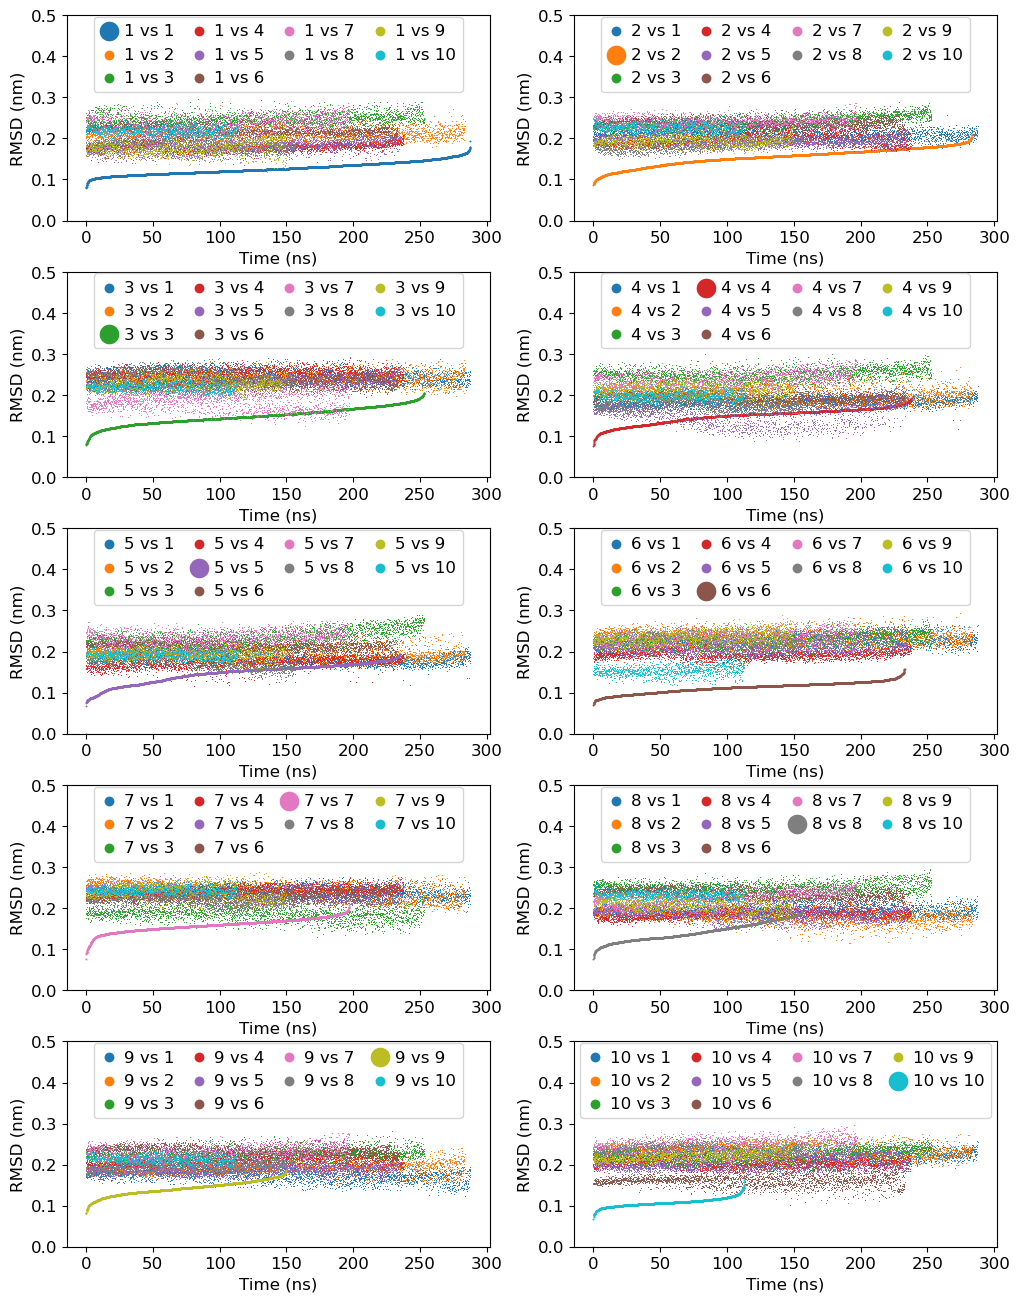

In [8]:
mpl.rcParams['font.size']=12
fig = plt.figure(figsize=(12,16))
fig.subplots_adjust(top=0.98, bottom=0.05, hspace=0.25)

for i in range(1,11):
    
    ax = fig.add_subplot(6, 2, i)
    
    for j in range(1,11):
        filename = 'clustered-rmsd/c{0}_c{1}.xvg'.format(i, j)
        label = "{0} vs {1}".format(i, j)
        data = read_xvg(filename) # read file
        if i==j:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=2)
        else:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=0.5)
        
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('RMSD (nm)')
    plt.legend(loc='upper center', ncol=4, markerscale=10, borderaxespad=0.1, columnspacing=1, handlelength=1, handletextpad=0.4)
    

plt.savefig('rmsd-comparison.png', dpi=300)
plt.show()

#### 3. Plotting PC vs PC cluster-wise

It will be done in two steps:

1. An input file will be prepared containing information about feature searial and their labels.
2. `gmx_clusterByFeatures featuresplot` will be used to generate the plot.

In [15]:
%%bash

# First step - preparation of input file
echo "1,2,PC-1,PC-2" > features-label.txt
echo "2,3,PC-2,PC-3" >> features-label.txt
echo "1,3,PC-1,PC-3" >> features-label.txt
echo "1,4,PC-1,PC-4" >> features-label.txt
cat features-label.txt

# Second step - plotting
gmx_clusterByFeatures featuresplot -i features-label.txt -feat proj.xvg -clid clid.xvg -lcols 6 -o protein-pca-PCs-vs-PCs.png

1,2,PC-1,PC-2
2,3,PC-2,PC-3
1,3,PC-1,PC-3
1,4,PC-1,PC-4


<img src="protein-pca-PCs-vs-PCs.png" width="900"/>  

#### 3. Cluster-ID with time

We will use `clid.xvg` obtained from the `cluster` subcommand to plot both cluster-id and also highlight the occurance of the given cluster. 

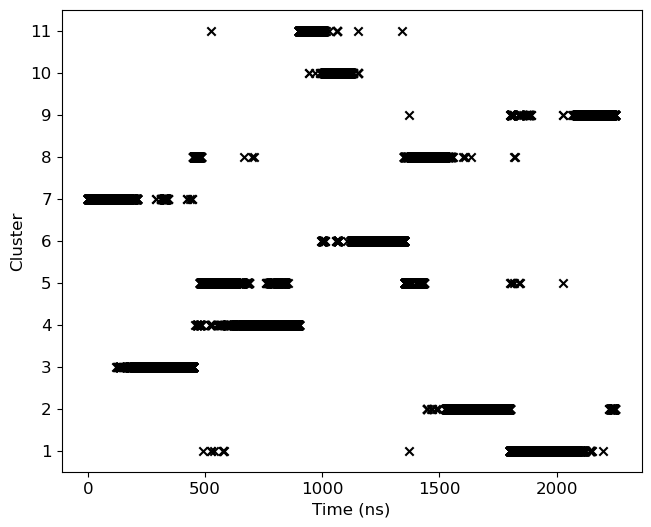

In [16]:
mpl.rcParams['font.size']=12

data=read_xvg('clid.xvg')
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(right=0.85)

ax = fig.add_subplot(111)
ax.scatter(data[0]/1000, data[1], marker='x', color='k')
ax.set_yticks(range(1,12))
ax.set_ylabel('Cluster')
ax.set_xlabel('Time (ns)')

plt.savefig('clid.png', dpi=300)
plt.show()